<a href="https://colab.research.google.com/github/gongx030/dream_PGE/blob/main/mode_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model training

In [1]:
RUNTIME = 'msi'

### Install external packages

In [33]:
!pip install tensorflow
!pip install biopython
!pip install sklearn
!pip install matplotlib

^C
ERROR: Operation cancelled by user
^C
^C


## Load Python packages

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from scipy import stats
# import session_info
from sklearn.metrics import r2_score
import pandas as pd
import re
import os
# from Bio.Seq import Seq
import matplotlib.pyplot as plt
import socket
import json
from collections import OrderedDict
import random as python_random

### TensorFlow setup

In [3]:
gpus = tf.config.list_physical_devices('GPU')
# for gpu in gpus:
#   tf.config.experimental.set_memory_growth(gpu, True)
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print('Physical GPUs: {}'.format(len(gpus)))
print('Logical GPUs: {}'.format(len(logical_gpus)))

Physical GPUs: 1
Logical GPUs: 1


In [4]:
socket.gethostname()

'c5329eef3a71'

## Parameters

In [17]:
ARGS = {
  'model_id' : 'm20220727e',
  'global_seed' : 123,
  'shuffle_size' : 1000,
  'max_width' : 100,
  'head_len' : 17,
  'tail_len' : 13,
  'pct_ds' : 1, # % of total data for training/testing,
  'train_split' : 0.95,
  'alphabets' : {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3, 'N' : 4, 'M' : 5},
  'learning_rate' : 0.001,
  'initial_epoch': 0,
  'epochs' : 20,
  'batch_size' : 180,
  'dropout_rate' : 0.1,
  'kmer': 10,
  'strides' : 1,
  'embedding_dim' : 512,
  'num_heads' : 8,
  'ff_mult' : 4,
  'num_projectors' : 32,
  'n_blocks_regressor' : 4,
  'warmup_steps' : 12500, # ~ 1 epoch
  'mask_ratio' : 0.05,
  'remote_sample_submission_file' : 'https://raw.githubusercontent.com/de-Boer-Lab/DREAM-2022/main/sample_submission.json',
}
if RUNTIME == 'msi':
  ARGS['remote_data_dir'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/training_data/pct_ds=' + str(ARGS['pct_ds']) + '/'
  ARGS['local_data_dir'] = re.sub('https://', './', ARGS['remote_data_dir'])
  ARGS['remote_checkpoint_dir'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/notebooks_msi/' + ARGS['model_id'] + '/tf_ckpts/'
  ARGS['remote_log_dir'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/notebooks_msi/' + ARGS['model_id'] + '/log/'
  ARGS['local_checkpoint_dir'] = re.sub('https://', './', ARGS['remote_checkpoint_dir'])
  ARGS['local_log_dir'] = re.sub('https://', './', ARGS['remote_log_dir'])
  ARGS['remote_test_data'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/test_sequences.txt.gz'
  ARGS['local_test_data'] = re.sub('https://', './', ARGS['remote_test_data'])
  ARGS['local_sample_submission_file'] = re.sub('https://', './', ARGS['remote_sample_submission_file'])
  ARGS['remote_prediction_file'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/predictions/' + ARGS['model_id'] + '/pred.json'
  ARGS['local_prediction_file'] = re.sub('https://', './', ARGS['remote_prediction_file'])
  ARGS['s3_prediction_file'] = re.sub('https://s3.msi.umn.edu', 's3://', ARGS['remote_prediction_file'])
  ARGS['remote_prediction_tsv_file'] = 'https://s3.msi.umn.edu/gongx030/projects/dream_PGE/predictions/' + ARGS['model_id'] + '/pred.tsv'
  ARGS['local_prediction_tsv_file'] = re.sub('https://', './', ARGS['remote_prediction_tsv_file'])
  ARGS['s3_prediction_tsv_file'] = re.sub('https://s3.msi.umn.edu', 's3://', ARGS['remote_prediction_tsv_file'])
else:
  ARGS['local_data_dir'] = '/content/drive/MyDrive/training_data/pct_ds=' + str(ARGS['pct_ds']) + '/'
  ARGS['local_checkpoint_dir'] = '/content/drive/MyDrive/' + ARGS['model_id'] + '/tf_ckpts/'
  ARGS['local_log_dir'] = '/content/drive/MyDrive/' + ARGS['model_id'] + '/log/'

### Set seeds

In [6]:
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(ARGS['global_seed'])

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
tf.random.set_seed(ARGS['global_seed'])

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
python_random.seed(ARGS['global_seed'])

## Functions

### pearson_r

https://www.tutorialexample.com/implement-pearson-correlation-coefficient-loss-in-tensorflow-tensorflow-tutorial/

In [7]:
def pearson_r(x, y):
    # Check for None or invalid inputs
  mx = tf.reduce_mean(x, axis = 0, keepdims = True)
  my = tf.reduce_mean(y, axis = 0, keepdims = True)
  xm = x - mx
  ym = y - my
  t1_norm = tf.nn.l2_normalize(xm, axis = 0)
  t2_norm = tf.nn.l2_normalize(ym, axis = 0)
  return tf.reduce_sum(tf.multiply(t1_norm, t2_norm))

# def pearson_r(y_true, y_pred):
#     x = y_true
#     y = y_pred
#     mx = tf.reduce_mean(x, axis=0)
#     my = tf.reduce_mean(y, axis=0)
#     xm, ym = x - mx, y - my
#     t1_norm = tf.nn.l2_normalize(xm, axis=0)
#     t2_norm = tf.nn.l2_normalize(ym, axis=0)
#     return tf.reduce_sum(tf.multiply(t1_norm, t2_norm))

In [8]:
x = np.random.rand(100)
y = np.random.rand(100)
print('pearson r (stats.pearsonr): {}'.format(stats.pearsonr(x, y)[0]))
print('pearson r (pearson_r): {}'.format(pearson_r(tf.expand_dims(x, 1), tf.expand_dims(y, 1))))

pearson r (stats.pearsonr): -0.09270195576139684
pearson r (pearson_r): -0.09270195576139688


### CustomSchedule

In [7]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Cast to float32 to fix TypeError
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

d_model = 128
learning_rate = CustomSchedule(d_model)
temp_learning_rate_schedule = CustomSchedule(d_model, warmup_steps=4000)

In [42]:
d_model = 128
learning_rate = CustomSchedule(d_model)
temp_learning_rate_schedule = CustomSchedule(d_model, warmup_steps=4000)

Text(0.5, 0, 'Train Step')

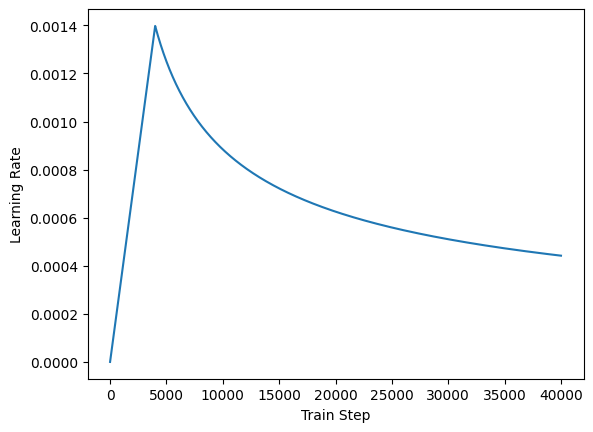

In [43]:
plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Read data

In [8]:
learning_rate = CustomSchedule(ARGS['embedding_dim'], warmup_steps = ARGS['warmup_steps'])
optimizer = tf.keras.optimizers.Adam(
    learning_rate, 
    beta_1=0.9, 
    beta_2=0.98, 
    epsilon=1e-9, 
    clipnorm=1.0
)
# optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1 = 0.9, beta_2 = 0.98, epsilon=1e-9, clipnorm=1., clipvalue=0.5)

In [9]:
# model.compile(
#   optimizer = optimizer,
#   loss=[tf.keras.losses.MeanSquaredError(), scc_loss],
#   metrics = [pearson_r, None],
# )
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")


Number of devices: 2


In [18]:
import tensorflow as tf
import os # Added for dummy data creation

input_dim = int(6)  # A, C, G, T, N, M
# Assuming ARGS is defined elsewhere (e.g., a dict or argparse result)
# Example ARGS for demonstration
ARGS = {
    'max_width': 10,
    'train_split': 0.8,
    'shuffle_size': 10000, # Make sure this is large enough for a good shuffle
    'batch_size': 32,
    'reduction_fraction': 1/1.0 # Added the fraction you want to keep
}
n_positions = ARGS['max_width'] * 2

# Correct path to your Kaggle dataset
kaggle_dataset_path = '/kaggle/input/dataset/s3.msi.umn.edu/gongx030/projects/dream_PGE/training_data/pct_ds=1'
# Using a dummy path for demonstration if running outside Kaggle
# kaggle_dataset_path = '/tmp/dummy_dataset_simple' # Replace with your actual path

# --- Dummy data creation for demonstration ---
# This part is just to make the code runnable outside Kaggle
# In your actual script, you would only need the loading part below
if not os.path.exists(kaggle_dataset_path):
    print(f"Creating dummy dataset at {kaggle_dataset_path}")
    # Create a reasonably large dummy dataset so reduction is noticeable
    dummy_data = [(tf.random.normal([20, input_dim]), tf.constant([0, 1])) for _ in range(2000)]
    dummy_ds_temp = tf.data.Dataset.from_generator(
        lambda: dummy_data,
        output_types=(tf.float32, tf.int32),
        output_shapes=([20, input_dim], [2])
    )
    tf.data.experimental.save(dummy_ds_temp, kaggle_dataset_path)
    print("Dummy dataset created.")
# --- End of dummy data creation ---


# Load the data
ds = tf.data.experimental.load(kaggle_dataset_path)

# Get the full dataset size (assuming cardinality is known)
# Be aware .cardinality() can be UNKNOWN_CARDINALITY, but keeping it simple for now.
n = int(ds.cardinality())
print('Full dataset size: %d' % (n))

# Shuffle the dataset BEFORE splitting
ds = ds.shuffle(ARGS['shuffle_size'], seed=1)

# Calculate split sizes
n_train = int(n * ARGS['train_split'])
n_test = n - n_train # Calculate test size explicitly for clarity

print('Calculated training split size: %d' % (n_train))
print('Calculated test split size: %d' % (n_test))


# Split into train and test using the calculated sizes
train_ds = ds.take(n_train)
test_ds = ds.skip(n_train)


# Get the cardinalities of the split datasets (should match calculated sizes if cardinality was known)
train_cardinality = int(train_ds.cardinality())
test_cardinality = int(test_ds.cardinality())

print('# training samples (original split size): %d' % (train_cardinality))
print('# test samples (original split size): %d' % (test_cardinality))

# --- Core Fix: Calculate the *smaller* sizes and use .take() ---

# Calculate the target smaller sizes based on the reduction fraction
smaller_train_size = max(1, int(train_cardinality * ARGS['reduction_fraction']))
smaller_test_size = max(1, int(test_cardinality * ARGS['reduction_fraction']))

# Use .take() with the *correctly calculated smaller sizes*
small_train_ds = train_ds.take(smaller_train_size)
small_test_ds = test_ds.take(smaller_test_size)
# --- End of Core Fix ---


# Print the sizes *after* reduction but *before* batching
# This shows the actual number of samples taken
print('# training samples (after reduction): %d' % (int(small_train_ds.cardinality())))
print('# test samples (after reduction): %d' % (int(small_test_ds.cardinality())))


# # Batch the smaller datasets
small_train_ds = small_train_ds.batch(ARGS['batch_size'])
small_test_ds = small_test_ds.batch(ARGS['batch_size'])

# Print the sizes *after* batching (shows number of batches)
print('# training batches (smaller): %d' % (int(small_train_ds.cardinality())))
print('# test batches (smaller): %d' % (int(small_test_ds.cardinality())))


# Check the structure
print('Small train dataset element spec:', small_train_ds.element_spec)

Full dataset size: 6737568
Calculated training split size: 5390054
Calculated test split size: 1347514
# training samples (original split size): 5390054
# test samples (original split size): 1347514
# training samples (after reduction): 5390054
# test samples (after reduction): 1347514
# training batches (smaller): 168440
# test batches (smaller): 42110
Small train dataset element spec: {'base': TensorSpec(shape=(None, 200), dtype=tf.uint8, name=None), 'seq': TensorSpec(shape=(None, 200), dtype=tf.uint8, name=None), 'expression': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}


In [19]:
# with strategy.scope():
def build_model(input_dim, embedding_dim, num_heads, ff_dim, num_layers, dropout_rate):
    # Input: integer-encoded sequences of shape (batch_size, 200)
    inputs = layers.Input(shape=(200,), dtype='int32', name='seq')
    
    # Embedding layer for nucleotides (0 to 5: A, C, G, T, N, M)
    embedding = layers.Embedding(input_dim=input_dim, output_dim=embedding_dim)(inputs)
    
    # Learned positional encoding for 200 positions
    positions = tf.range(200, dtype=tf.int32)
    pos_encoding = layers.Embedding(input_dim=200, output_dim=embedding_dim)(positions)
    x = embedding + pos_encoding
    
    # Transformer Encoder Layers
    for _ in range(num_layers):
        # Multi-head self-attention
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        # Feed-forward network
        ffn_output = layers.Dense(ff_dim, activation='relu')(x)
        ffn_output = layers.Dense(embedding_dim)(ffn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)
    
    # Global average pooling to reduce sequence to a single vector
    pooled = layers.GlobalAveragePooling1D()(x)
    
    # Output layer: predict expression value
    outputs = layers.Dense(1)(pooled)
    
    # Build the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Hyperparameters
input_dim = 6        # For A, C, G, T, N, M
embedding_dim = 64   # Embedding size
num_heads = 4        # Number of attention heads
ff_dim = 128         # Feed-forward network dimension
num_layers = 2       # Number of transformer layers
dropout_rate = 0.1   # Dropout rate (not used here for simplicity)

# Build the model
model = build_model(input_dim, embedding_dim, num_heads, ff_dim, num_layers, dropout_rate)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ seq (InputLayer)          │ (None, 200)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 200, 64)        │            384 │ seq[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_5 (Add)               │ (None, 200, 64)        │              0 │ embedding_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_2    │ (None, 200, 64)        │         66,368 │ add_5[0][0],           │
│ (MultiHeadAttention)      │                        │                │ add_5[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_6 (Add)               │ (None, 200, 64)        │              0 │ add_5[0][0],           │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_4     │ (None, 200, 64)        │            128 │ add_6[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 200, 128)       │          8,320 │ layer_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 200, 64)        │          8,256 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 200, 64)        │              0 │ layer_normalization_4… │
│                           │                        │                │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_5     │ (None, 200, 64)        │            128 │ add_7[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_3    │ (None, 200, 64)        │         66,368 │ layer_normalization_5… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_8 (Add)               │ (None, 200, 64)        │              0 │ layer_normalization_5… │
│                           │                        │                │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_6     │ (None, 200, 64)        │            128 │ add_8[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 200, 128)       │          8,320 │ layer_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 200, 64)        │          8,256 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)          

 Total params: 166,849 (651.75 KB)

 Trainable params: 166,849 (651.75 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# with strategy.scope():
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
      def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
    
        self.warmup_steps = warmup_steps
    
      def __call__(self, step):
            step = tf.cast(step, tf.float32)  # Cast to float32 to fix TypeError
            arg1 = tf.math.rsqrt(step)
            arg2 = step * (self.warmup_steps ** -1.5)
            return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
          
      def get_config(self):
            return {
                'd_model': float(self.d_model),  # Convert to float for serialization
                'warmup_steps': float(self.warmup_steps)
            }
    
d_model = 128
learning_rate = CustomSchedule(d_model)
temp_learning_rate_schedule = CustomSchedule(d_model, warmup_steps=4000)


In [21]:
# with strategy.scope():
    # Define Pearson correlation metric
learning_rate = CustomSchedule(512, warmup_steps = 12500)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, 
    beta_1=0.9, 
    beta_2=0.98, 
    epsilon=1e-9, 
    clipnorm=1.0
)

strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.MeanSquaredError(),  # Single loss for expression
    metrics=[pearson_r],  # Metric for expression
)

Number of devices: 1


In [22]:
# # Map dataset to (inputs, labels)
# train_ds_mapped = train_ds.map(lambda x: (x['seq'], x['expression']))
# test_ds_mapped = test_ds.map(lambda x: (x['seq'], x['expression']))

# Map datasets to (inputs, labels)
small_train_ds_mapped = small_train_ds.map(lambda x: (x['seq'], x['expression']))
small_test_ds_mapped = small_test_ds.map(lambda x: (x['seq'], x['expression']))

In [23]:
# # Define early stopping callback
# early_stopping = keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=4,
#     restore_best_weights=True
# )

# # # Train the model
# # history = model.fit(
# #     train_ds_mapped,
# #     validation_data=test_ds_mapped,
# #     epochs=20,
# #     callbacks=[early_stopping],
# #     verbose=1
# # )


# # Train the model on the smaller dataset
# history = model.fit(
#     small_train_ds_mapped,
#     validation_data=small_test_ds_mapped,
#     epochs=20,
#     callbacks=[early_stopping],
#     verbose=1
# )

# # Evaluate the model on the smaller test dataset
# test_loss, test_pearson_r = model.evaluate(small_test_ds_mapped, verbose=1)

# print(f"Test Loss (MSE) on Smaller Test Set: {test_loss:.4f}")
# print(f"Test Pearson Correlation on Smaller Test Set: {test_pearson_r:.4f}")


# # st_loss, test_pearson_r = model.evaluate(test_ds_mapped, verbose=1)

# # print(f"Test Loss (MSE) on Test Set: {test_loss:.4f}")
# # print(f"Test Pearson Correlation on Test Set: {test_pearson_r:.4f}")

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

# Define ModelCheckpoint callback to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Train the model on the smaller dataset
history = model.fit(
    small_train_ds_mapped,
    validation_data=small_test_ds_mapped,
    epochs=20,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Evaluate the model on the smaller test dataset
test_loss, test_pearson_r = model.evaluate(small_test_ds_mapped, verbose=1)

print(f"Test Loss (MSE) on Smaller Test Set: {test_loss:.4f}")
print(f"Test Pearson Correlation on Smaller Test Set: {test_pearson_r:.4f}")

# Save the final model (including weights and architecture)
model.save('final_model.h5')

# Optionally save weights only
model.save_weights('model_weights.we.h5')

Epoch 1/20
168440/168440 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8174 - pearson_r: 2.7016e-10
Epoch 1: val_loss improved from inf to 0.75204, saving model to best_model.h5
168440/168440 ━━━━━━━━━━━━━━━━━━━━ 1737s 10ms/step - loss: 0.8174 - pearson_r: 2.7016e-10 - val_loss: 0.7520 - val_pearson_r: -5.4319e-10
Epoch 2/20
168437/168440 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7398 - pearson_r: 3.1806e-10
Epoch 2: val_loss improved from 0.75204 to 0.70446, saving model to best_model.h5
168440/168440 ━━━━━━━━━━━━━━━━━━━━ 1777s 11ms/step - loss: 0.7398 - pearson_r: 3.1806e-10 - val_loss: 0.7045 - val_pearson_r: -3.5603e-10
Epoch 3/20
 29376/168440 ━━━━━━━━━━━━━━━━━━━━ 21:05 9ms/step - loss: 0.6893 - pearson_r: -1.4741e-09